In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import sys
display(sys.version)

'3.11.5 (main, Sep 11 2023, 13:54:46) [GCC 11.2.0]'

In [2]:
import pomegranate
from pomegranate import *
import anndata

display(pomegranate.__version__)

'0.14.8'

# Import hDel-v3 (low MOI) & hDel-v4 (high MOI) bustools-filtered sgRNA UMIs

In [3]:
path = '/home/tyler/Documents/kallisto_bustools_kITE/'

kb3 = anndata.read_h5ad(path + 'hDel-v3_sgRNA_kITE_counts_filtered_concatenate.h5ad')
kb4 = anndata.read_h5ad(path + 'hDel-v4_sgRNA_kITE_counts_filtered_concatenate.h5ad')

kb3, kb4

(AnnData object with n_obs × n_vars = 25589 × 160
     obs: 'batch'
     var: 'feature_name',
 AnnData object with n_obs × n_vars = 19126 × 923
     obs: 'batch'
     var: 'feature_name')

In [4]:
kb_df3, kb_df4 = kb3.to_df(), kb4.to_df()

In [5]:
#sgRNAs must have at least 5 UMIs in at least 50 Cell Barcodes

kb_df3 = kb_df3.loc[:, (kb_df3 >= 5).sum() >= 50]
kb_df4 = kb_df4.loc[:, (kb_df4 >= 5).sum() >= 50]

# Poisson-Gaussian mixture model from Replogle et al., 2020

In [6]:
def PoissonGaussian(sgRNA: str, df, UMI_threshold):
    
    cell_barcodes = df[sgRNA].where(lambda x: x > UMI_threshold).dropna().index
    UMIs = df[sgRNA].where(lambda x: x > UMI_threshold).dropna().values
    log2_UMIs = np.log2(df[sgRNA].where(lambda x: x > UMI_threshold).dropna()).values.reshape(-1,1)
    
    i = 0
    #array of 1000 linearly spaced points between -2 and max(log2_UMIs)+2
    gmm_x = np.linspace(-2, max(log2_UMIs)+2, 1000)
    #run until variable i != 0
    while i == 0:
        #create a model using the GeneralMixtureModel.from_samples function, which is a mixture model of two distributions: PoissonDistribution and NormalDistribution
        model = GeneralMixtureModel.from_samples([PoissonDistribution, NormalDistribution], 2, log2_UMIs)
        #check that the model converges (no NaN) and that the Poisson distribution is the lower component by using an if-else loop
        #if there is any NaN in the probability of the model, set i to 0 to keep the loop running
        if numpy.isnan(model.probability(gmm_x)).any():
            i = 0
        else:
            #check that Poisson distribution is the lower component
            if model.distributions[0].name is 'PoissonDistribution':
                #if the first component of the model is PoissonDistribution and has a smaller parameter than the second component, set i to 1 to exit the loop
                if model.distributions[0].parameters[0] < model.distributions[1].parameters[0]:
                    i = 1    
                else:
                    i = 0
            #if the first component has a bigger parameter than the second, set i to 0 to keep the loop running
            elif model.distributions[0].parameters[0] > model.distributions[1].parameters[0]:
                i = 0
    
    plot_mixture_model(sgRNA, model, log2_UMIs, gmm_x)
    
    #second column is probability of belonging to second component
    return pd.DataFrame({'cell_barcode': cell_barcodes, 'sg_ID': sgRNA, 'UMIs': UMIs, 'PoissonGaussian': model.predict_proba(log2_UMIs)[:,1]})

def plot_mixture_model(sgRNA, model, log2_UMIs, gmm_x):
    fig, ax = plt.subplots(figsize=(6,3))
    plt.hist(log2_UMIs, bins=50,  color='whitesmoke', density=True, edgecolor='black')
    plt.plot(gmm_x, model.distributions[0].probability(gmm_x)*np.exp(model.weights[0]), color='black', ls='--')
    plt.plot(gmm_x, model.distributions[1].probability(gmm_x)*np.exp(model.weights[1]), color='red', ls='--')
    plt.axvline(np.log2(10), c='grey', ls='--', lw=1, zorder=0)
    ax.set(xlabel='Log$_2$ '+sgRNA+' UMIs', ylabel='Density')
    ax.set_xlim(left=-0.1)
    plt.gca().spines['right'].set_color('none')
    plt.gca().spines['top'].set_color('none')
    plt.show()
    plt.close()

<>:20: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:20: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_456399/3961668684.py:20: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if model.distributions[0].name is 'PoissonDistribution':


# Perform mixture model sgRNA to cell assignments

In [7]:
#drop hDel-v4 sgRNAs for which the mixture model fails to converge (very few UMIs, do belong to a mixture of Poisson-Gaussian distributions)

no_converge = ['hDel_1273_1_H3K4me1_H3K27ac_CUT_Tag_4', 'hDel_3813_1_H3K4me1_H3K27ac_CUT_Tag_5', 'hDel_4959_1_Omni_ATAC_3', 
               'hDel_5502_1_Omni_ATAC_5', 'hDel_6065_1_Omni_ATAC_3', 'hDel_6111_1_Omni_ATAC_3', 
               'hDel_4959_1_Omni_ATAC_4', 'hDel_6602_1_Omni_ATAC_3', 'hDel_5049_1_Omni_ATAC_2']

kb_df4.drop(columns=no_converge, errors='ignore', inplace=True)

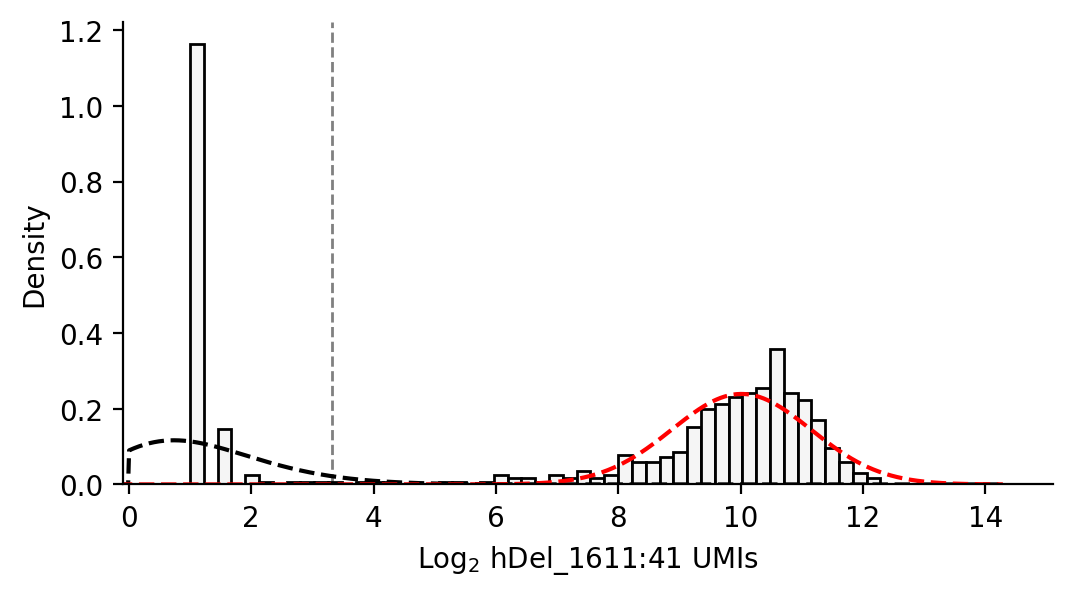

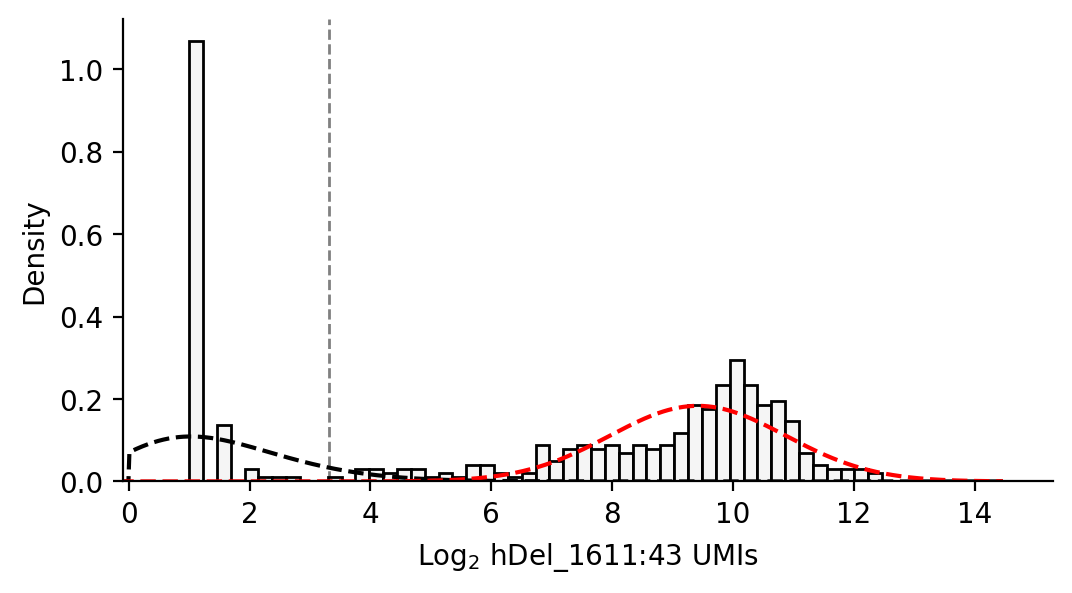

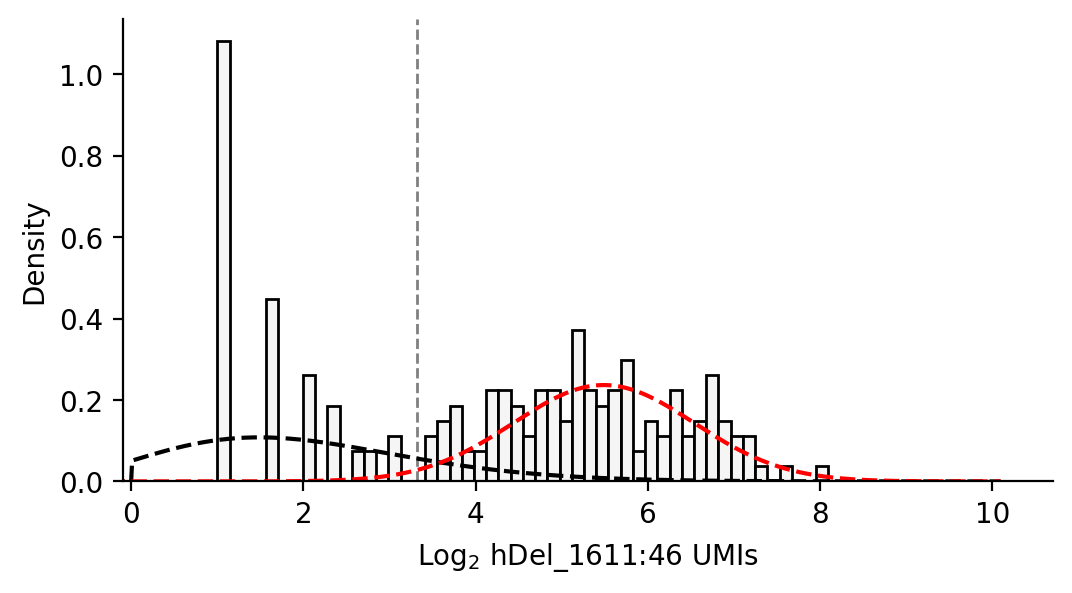

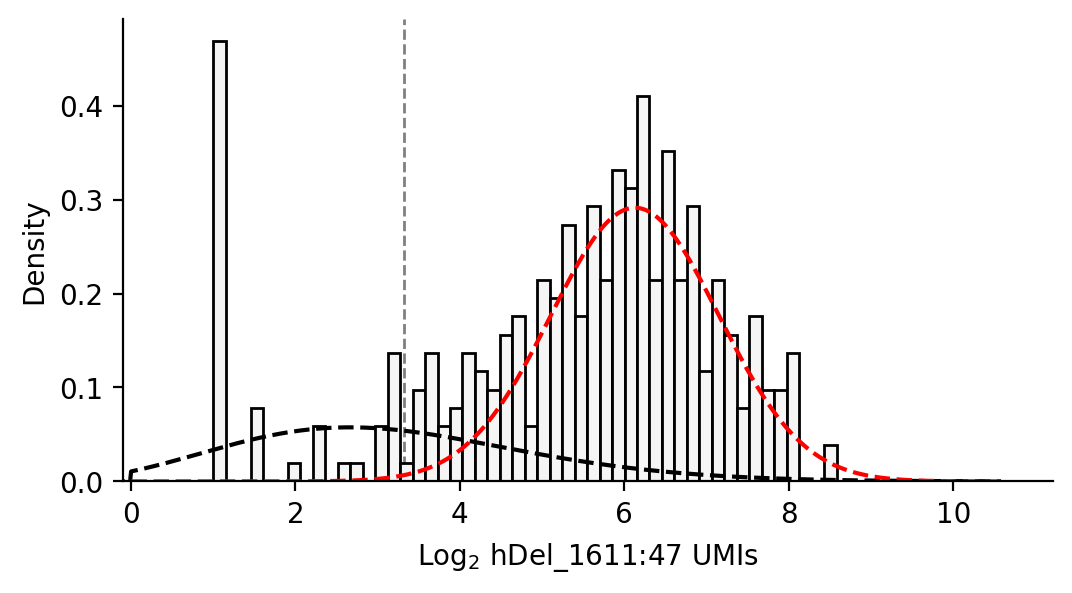

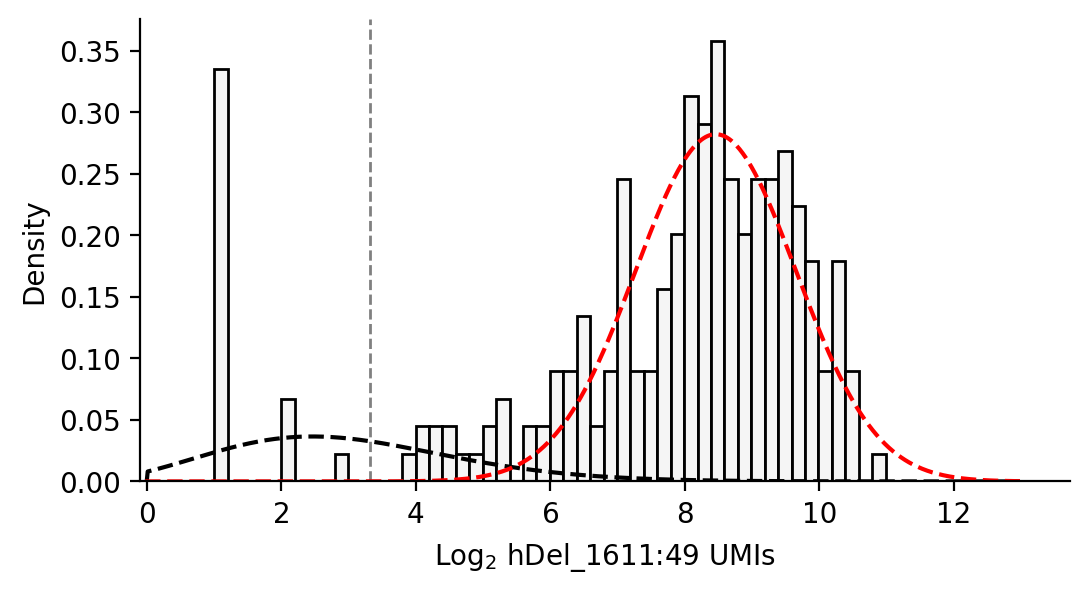

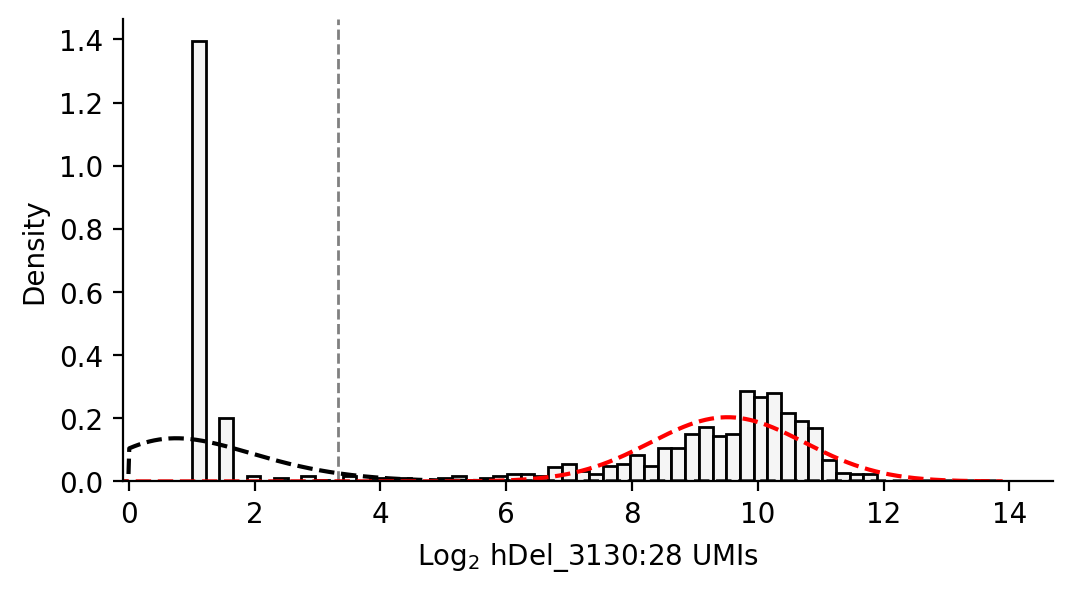

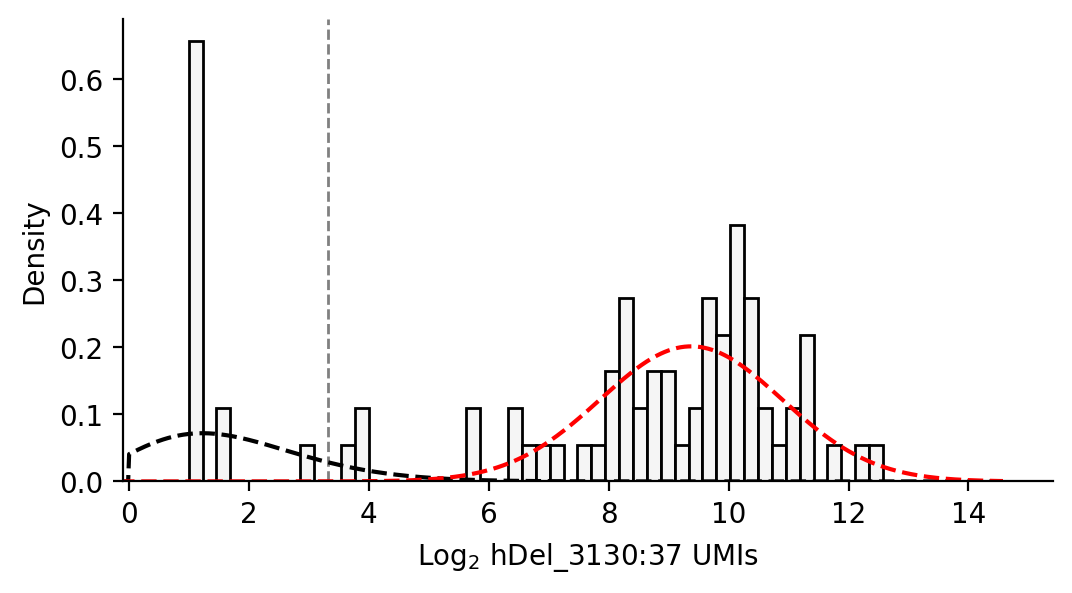

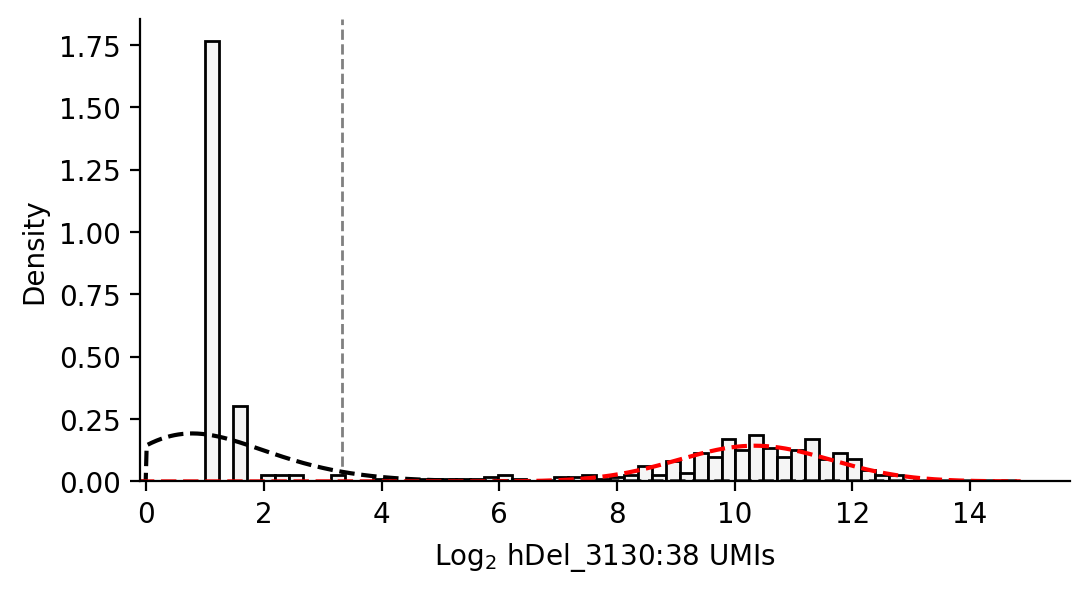

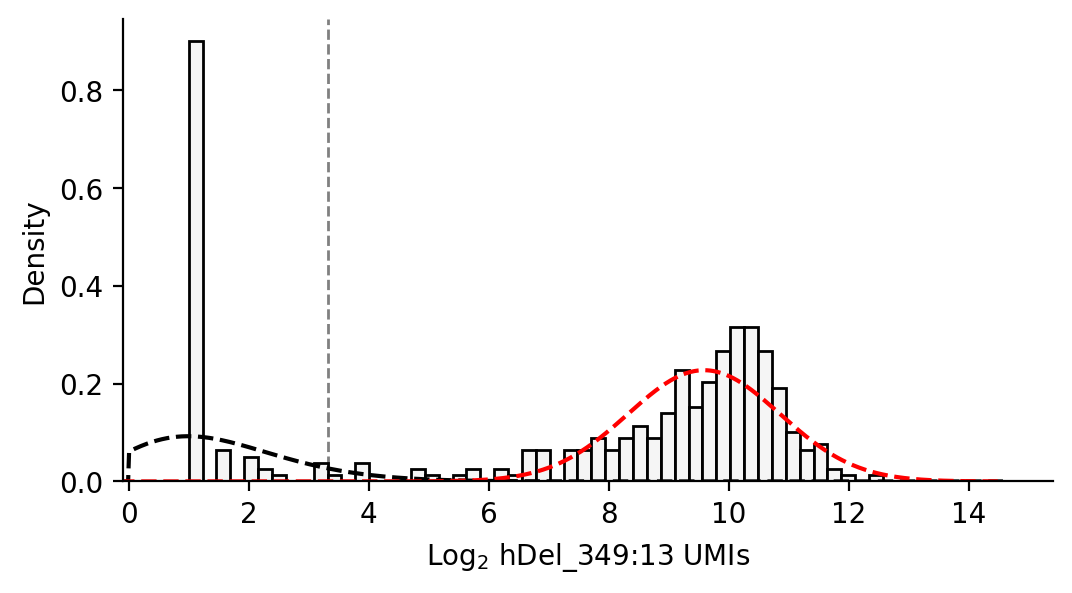

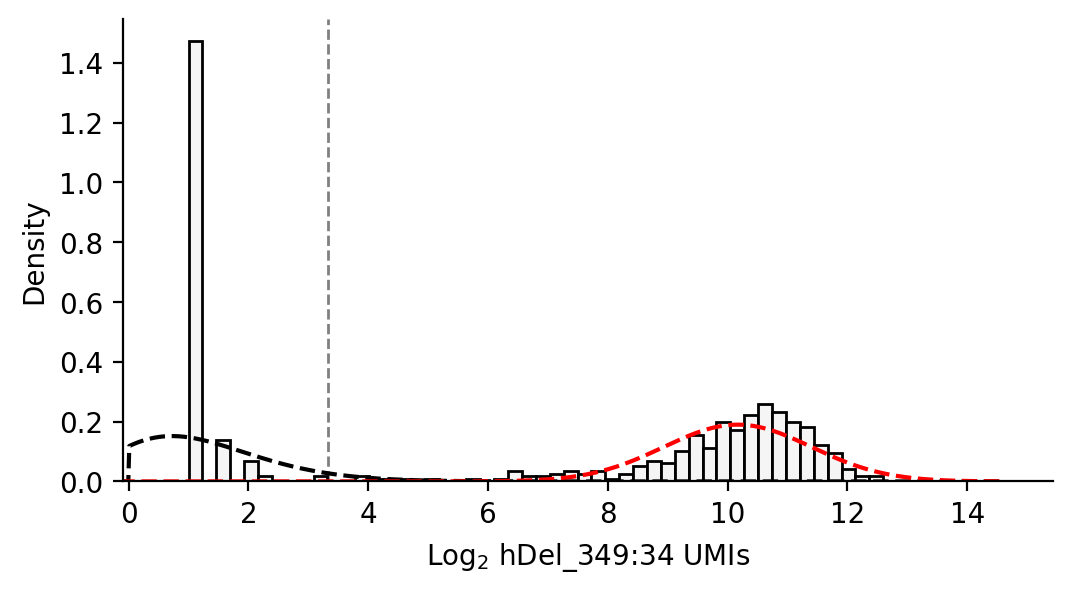

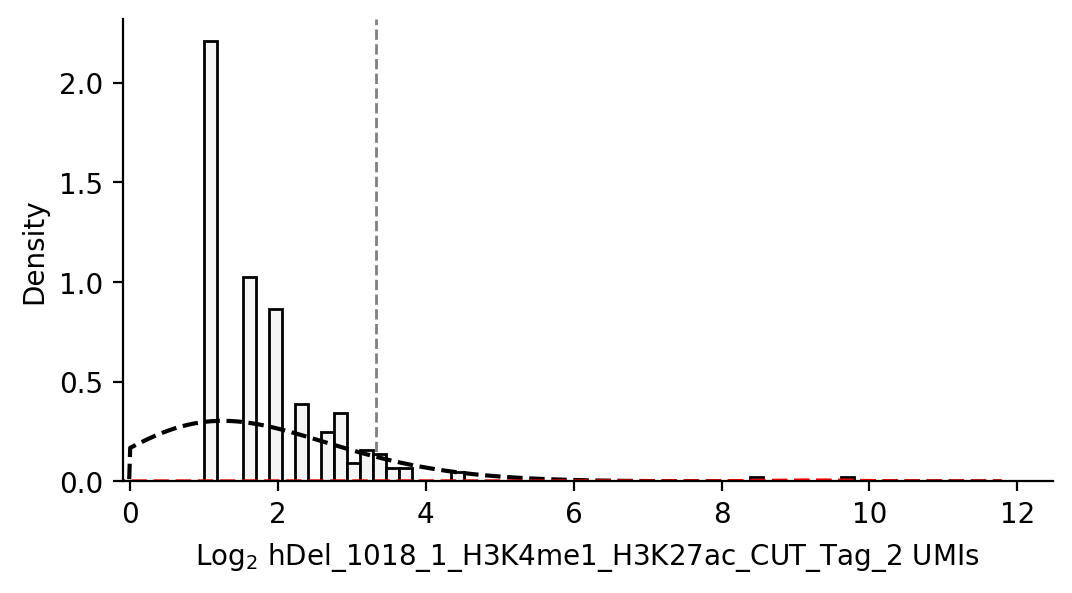

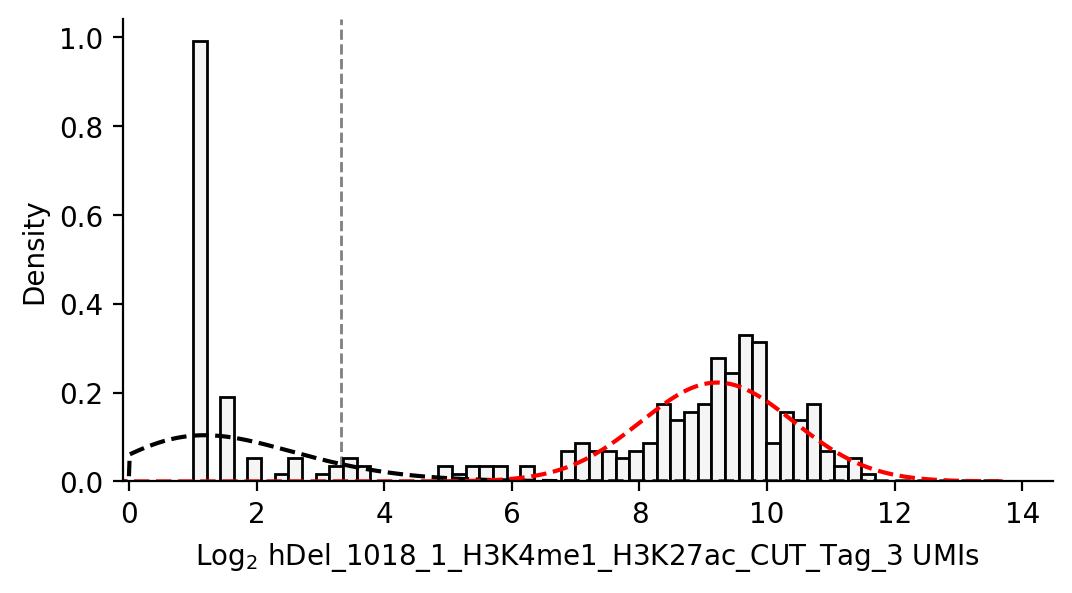

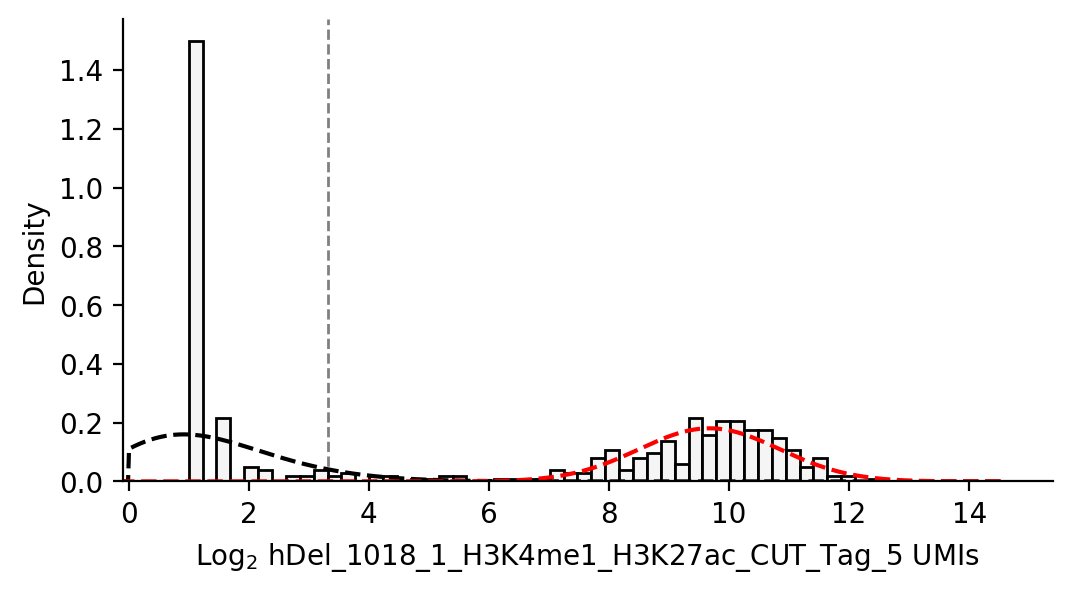

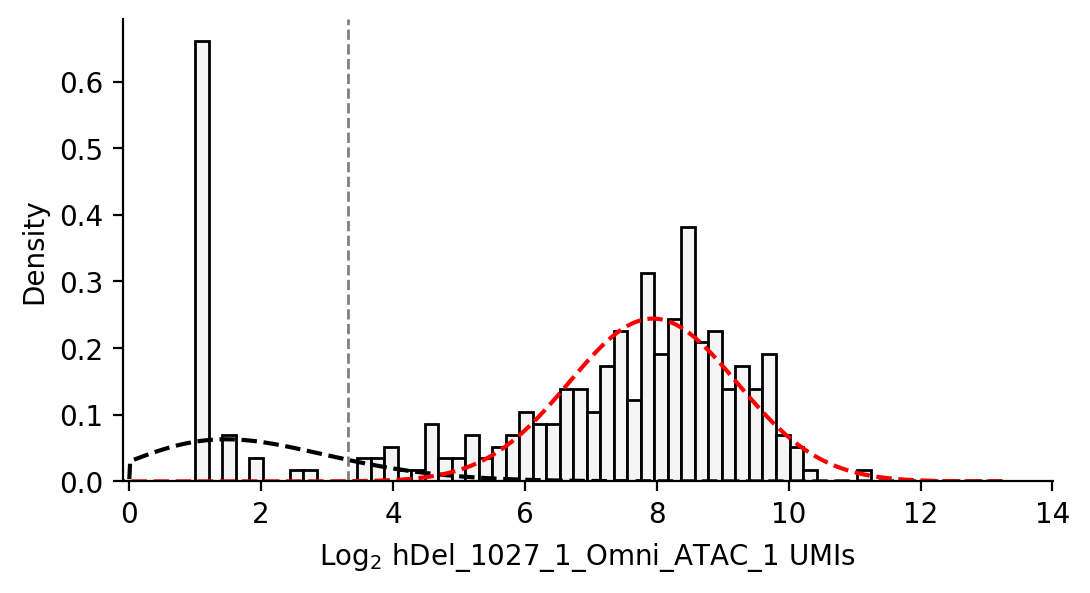

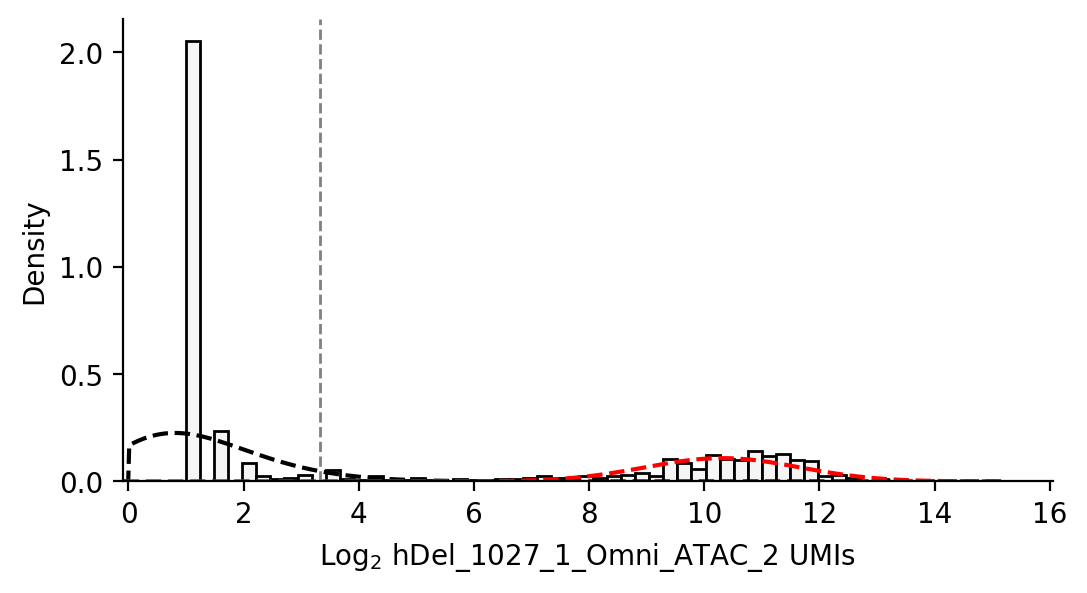

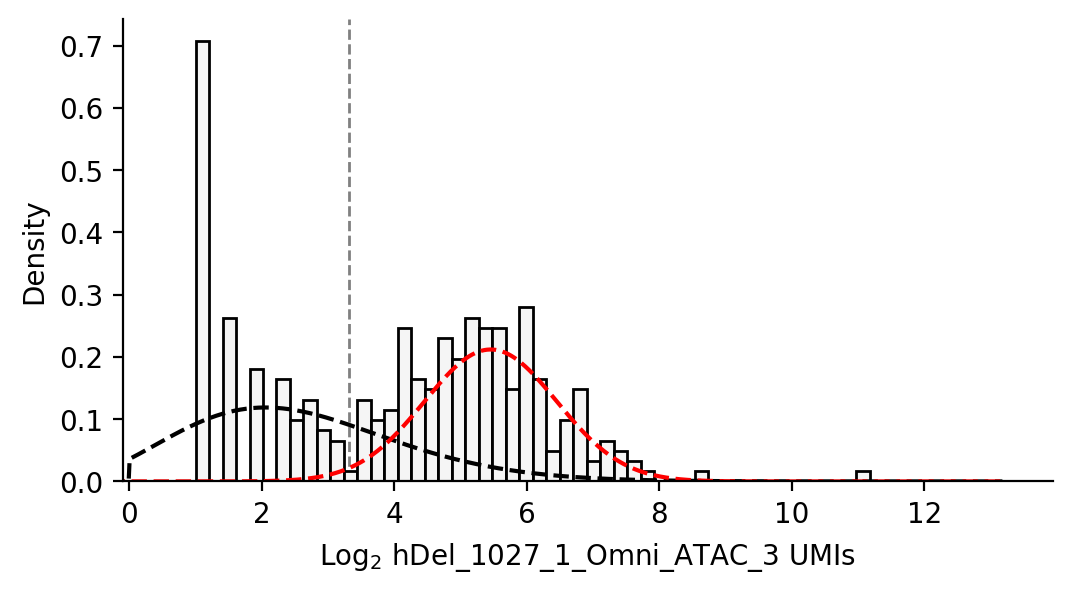

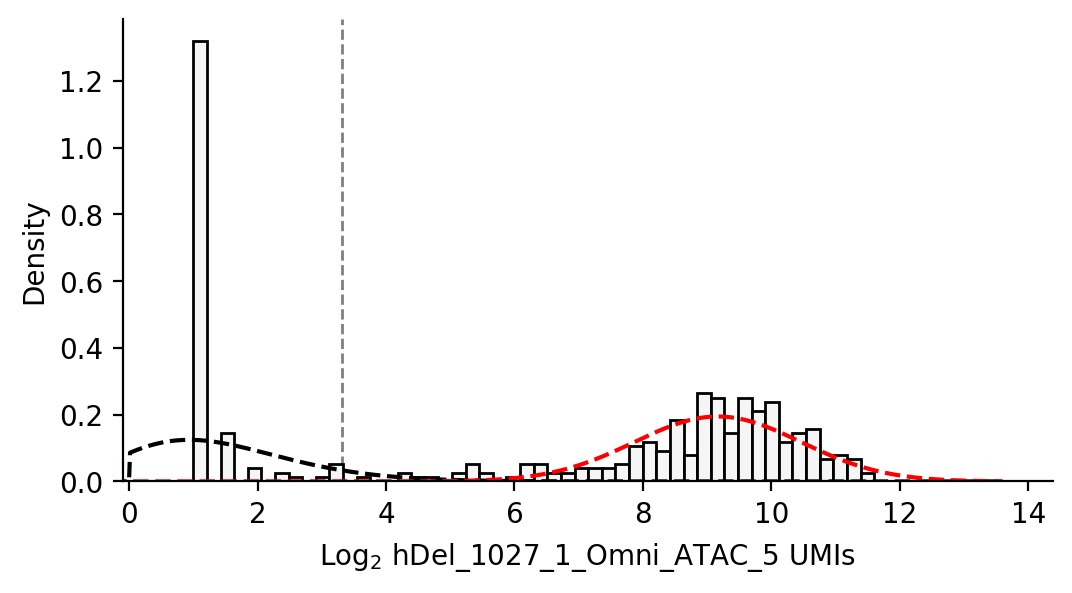

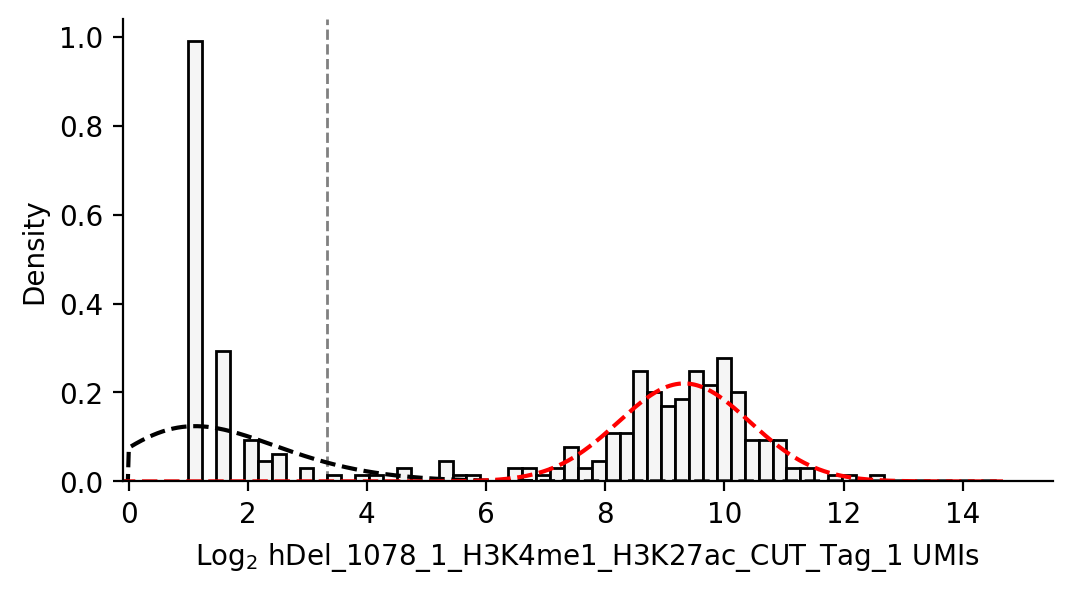

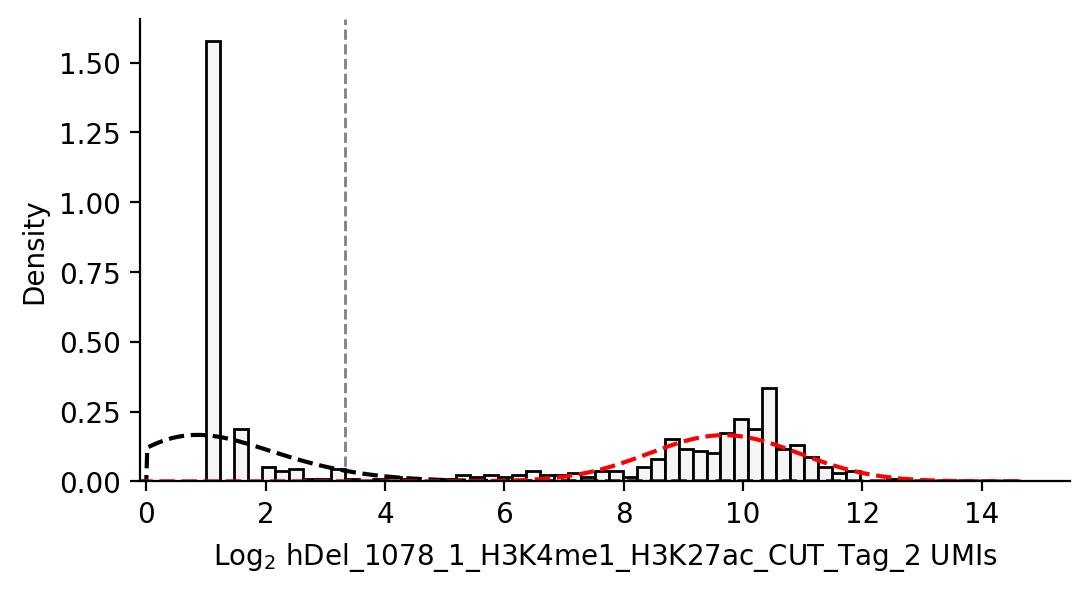

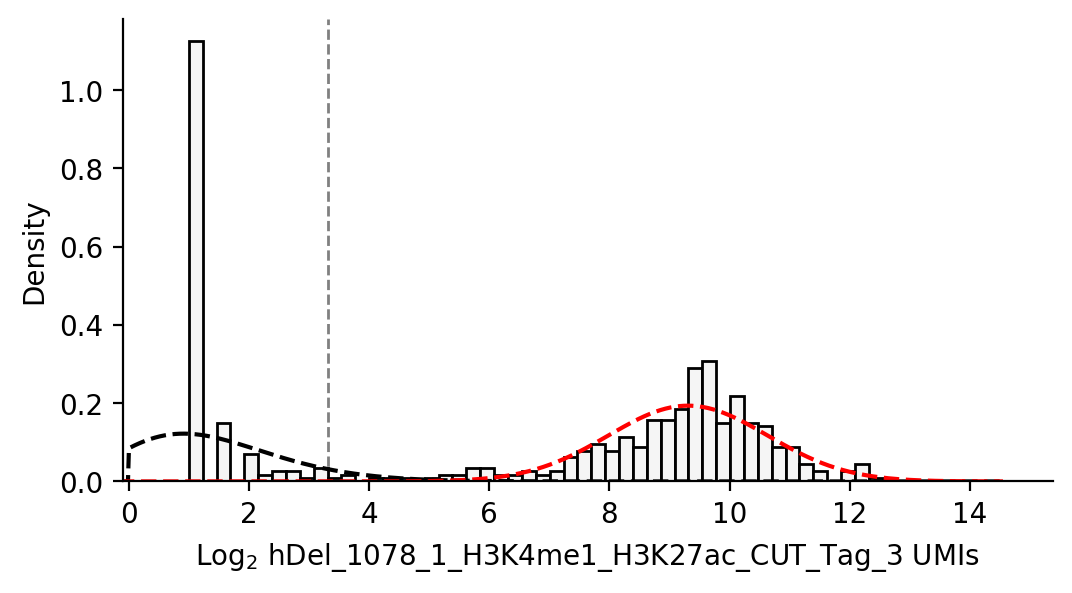

In [8]:
#perform sgRNA-cell assignments

#demonstration with 10 sgRNAs (df.columns[:10]) in hDel-v3 and hDel-v4

assignments_kb3 = [PoissonGaussian(sgRNA, kb_df3, 1) for sgRNA in kb_df3.columns[:10]]
assignments_kb4 = [PoissonGaussian(sgRNA, kb_df4, 1) for sgRNA in kb_df4.columns[:10]]

PGMM_sgRNAs_kb3 = pd.concat(assignments_kb3)
PGMM_sgRNAs_kb4 = pd.concat(assignments_kb4)

# Filter sgRNA-cell assignments

In [9]:
#hDel-v3, low MOI

#filters: 
    #>99% probability of belonging to second component
    #>10 UMIs
    #1 sgRNA per cell
    #>25 cells per sgRNA

PGMM_sgRNAs_kb3_filtered = PGMM_sgRNAs_kb3.loc[(PGMM_sgRNAs_kb3['PoissonGaussian'] >= 0.99) & (PGMM_sgRNAs_kb3['UMIs'] >= 10)].groupby('cell_barcode').filter(lambda x: len(x) == 1).groupby('sg_ID').filter(lambda x: len(x) >= 25)
PGMM_sgRNAs_kb3_filtered

,cell_barcode,sg_ID,UMIs,PoissonGaussian
0,AAACGAACACATTCTT_GEM1,hDel_1611:41,546.0,0.999990
1,AAAGAACTCGAGTGGA_GEM1,hDel_1611:41,3417.0,1.000000
3,AACAAAGGTCCAGCAC_GEM1,hDel_1611:41,3624.0,1.000000
5,AACTTCTCAGAGTGAC_GEM1,hDel_1611:41,1724.0,1.000000
6,AAGACTCCAGGCACTC_GEM1,hDel_1611:41,866.0,0.999998
...,...,...,...,...
494,TTCACGCTCCGTATGA_GEM5,hDel_349:34,1522.0,0.999999
495,TTCCAATGTGGGATTG_GEM5,hDel_349:34,4298.0,1.000000
497,TTCCGTGAGAATCGCG_GEM5,hDel_349:34,1600.0,1.000000
498,TTCCTCTCAGCTACCG_GEM5,hDel_349:34,410.0,0.999948


In [10]:
#hDel-v4, high MOI

#filters: 
    #>50% probability of belonging to second component
    #>10 UMIs
    #>100 cells per sgRNA

PGMM_sgRNAs_kb4_filtered = PGMM_sgRNAs_kb4.loc[(PGMM_sgRNAs_kb4['PoissonGaussian'] > 0.50) & (PGMM_sgRNAs_kb4['UMIs'] >= 10)].groupby('sg_ID').filter(lambda x: len(x) >= 100)
PGMM_sgRNAs_kb4_filtered

,cell_barcode,sg_ID,UMIs,PoissonGaussian
0,ACAAGCTTCGAGCACC_GEM1,hDel_1018_1_H3K4me1_H3K27ac_CUT_Tag_3,1718.0,0.999991
1,ACTATGGGTGAAGCGT_GEM1,hDel_1018_1_H3K4me1_H3K27ac_CUT_Tag_3,1922.0,0.999992
3,ATTACCTGTAGTCGGA_GEM1,hDel_1018_1_H3K4me1_H3K27ac_CUT_Tag_3,1249.0,0.999986
4,ATTGTTCAGACCAAAT_GEM1,hDel_1018_1_H3K4me1_H3K27ac_CUT_Tag_3,725.0,0.999960
5,ATTGTTCCATGACTTG_GEM1,hDel_1018_1_H3K4me1_H3K27ac_CUT_Tag_3,855.0,0.999972
...,...,...,...,...
488,TTGCTGCTCACTTCTA_GEM5,hDel_1078_1_H3K4me1_H3K27ac_CUT_Tag_3,1096.0,0.999995
489,TTGTGGAAGGGATCTG_GEM5,hDel_1078_1_H3K4me1_H3K27ac_CUT_Tag_3,295.0,0.999802
490,TTTACGTAGAGAGCCT_GEM5,hDel_1078_1_H3K4me1_H3K27ac_CUT_Tag_3,95.0,0.981367
491,TTTCACAGTGCAACAG_GEM5,hDel_1078_1_H3K4me1_H3K27ac_CUT_Tag_3,235.0,0.999551
